In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def prepare(fname:str, category:str, date_format: str):
    df = pd.read_csv(fname)
    df = pd.melt(df, id_vars=['Province/State', 'Country/Region'], value_vars=[c for c in df.columns if c[0] in '0123456789']) \
           .rename(columns={'variable':'period', 'value': category, 'Province/State': 'province', 'Country/Region': 'country'})
    
    # Parse date from perdiod string and remove the period string as
    # it confuses the following merge processess
    df['date'] = pd.to_datetime(df['period'], format=date_format)
    df = df[[c for c in df.columns if c != 'period']]
    
    return df

dfc = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 'confirmed', '%m/%d/%y')
dfd = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 'deaths', '%m/%d/%y')
dfr = prepare('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', 'recovered', '%m/%d/%Y')

df = pd.merge(dfc, dfd)
df = pd.merge(df, dfr)
df = df.groupby([df.country, df.date]).sum().reset_index()
df

country       date  confirmed  deaths  recovered
0      Afghanistan 2020-01-22          0       0          0
1      Afghanistan 2020-01-23          0       0          0
2      Afghanistan 2020-01-24          0       0          0
3      Afghanistan 2020-01-25          0       0          0
4      Afghanistan 2020-01-26          0       0          0
...            ...        ...        ...     ...        ...
10453     Zimbabwe 2020-03-20          1       0          0
10454     Zimbabwe 2020-03-21          3       0          0
10455     Zimbabwe 2020-03-22          3       0          0
10456     Zimbabwe 2020-03-23          3       1          0
10457     Zimbabwe 2020-03-24          3       1          0

[10458 rows x 5 columns]

In [3]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.sample(5)

pop_est continent         name iso_a3  gdp_md_est  \
82   40969443    Africa      Algeria    DZA   609400.00   
79    4543126      Asia    Palestine    PSE    21220.77   
12    7531386    Africa      Somalia    SOM     4719.00   
127   8236303    Europe  Switzerland    CHE   496300.00   
15   12075985    Africa         Chad    TCD    30590.00   

                                              geometry  
82   POLYGON ((-8.68440 27.39574, -8.66512 27.58948...  
79   POLYGON ((35.39756 31.48909, 34.92741 31.35344...  
12   POLYGON ((41.58513 -1.68325, 40.99300 -0.85829...  
127  POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...  
15   POLYGON ((23.83766 19.58047, 23.88689 15.61084...

In [4]:
world_c19 = world.merge(df[df.date == '2020-03-23'], how='left', left_on='name', right_on='country')
world_c19 = world_c19.assign(case_per_pop=lambda x: x.confirmed / x.pop_est)
world_c19 = world_c19.assign(deaths_per_pop=lambda x: x.deaths / x.pop_est)

# Until the source data project adopts ISO country codes, we have lots of
# failed matches that we have to ignore

world_c19

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry              country  \
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...                 Fiji   
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...             Tanzania   
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...                  NaN   
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...                  NaN   
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...                  NaN   
..                                                 ...                  ...   
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...               Serbia   
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...           Montenegro   
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...                  NaN   
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  Trinidad and Tobago   
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...                  NaN   

          date  confirmed  deaths  recovered  case_per_pop  deaths_per_pop  
0   2020-03-23        3.0     0.0        0.0  3.257548e-06    0.000000e+00  
1   2020-03-23       12.0     0.0        0.0  2.224243e-07    0.000000e+00  
2          NaT        NaN     NaN        NaN           NaN             NaN  
3          NaT        NaN     NaN        NaN           NaN             NaN  
4          NaT        NaN     NaN        NaN           NaN             NaN  
..         ...        ...     ...        ...           ...             ...  
172 2020-03-23      249.0     3.0        1.0  3.501605e-05    4.218802e-07  
173 2020-03-23       27.0     1.0        0.0  4.202008e-05    1.556299e-06  
174        NaT        NaN     NaN        NaN           NaN             NaN  
175 2020-03-23       51.0     0.0        1.0  4.186477e-05    0.000000e+00  
176        NaT        NaN     NaN        NaN           NaN             NaN  

[177 rows x 13 columns]

In [5]:
world_c19[(world_c19.country == 'Luxembourg')|(world_c19.country == 'France')]

pop_est continent        name iso_a3  gdp_md_est  \
43   67106161    Europe      France    -99   2699000.0   
128    594130    Europe  Luxembourg    LUX     58740.0   

                                              geometry     country       date  \
43   MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...      France 2020-03-23   
128  POLYGON ((6.04307 50.12805, 6.24275 49.90223, ...  Luxembourg 2020-03-23   

     confirmed  deaths  recovered  case_per_pop  deaths_per_pop  
43     20185.0   863.0     2206.0      0.000301        0.000013  
128      875.0     8.0        6.0      0.001473        0.000013

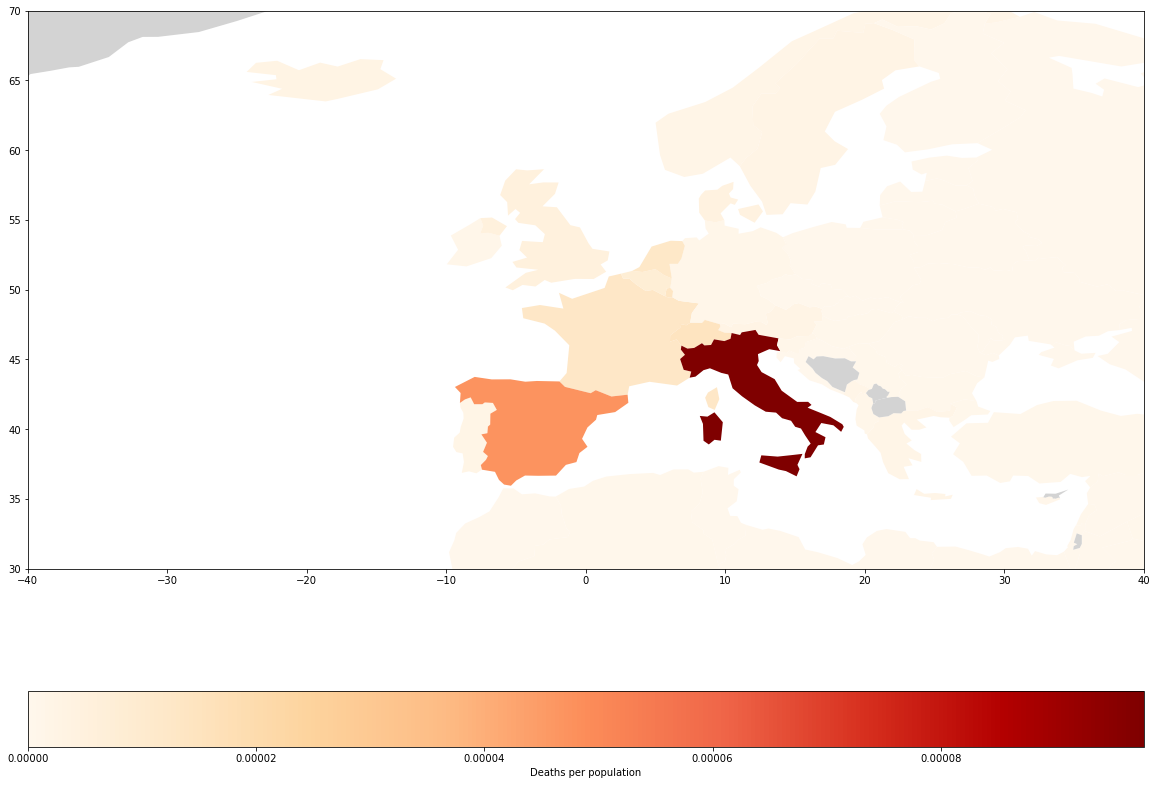

In [6]:
ax = world_c19.plot(figsize=(20,15), 
                    cmap='OrRd', 
                    column='deaths_per_pop', 
                    legend=True, 
                    missing_kwds={'color': 'lightgrey'},
                    legend_kwds={'label': "Deaths per population",
                                 'orientation': "horizontal"
                                }
                   )
ax.set_xlim(-40, 40)
ax.set_ylim(30, 70)
plt.show()